In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torchvision.transforms as transforms
from Anchor.anchor import Anchor, Tasktype
from torchvision.models import inception_v3, resnet18
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

%load_ext autoreload
%autoreload 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([162])
tensor(162)
beagle 0.9371574521064758
tensor(166)
Walker hound 0.02404705062508583
tensor(167)
English foxhound 0.01230653002858162
tensor(161)
basset 0.002038035076111555
tensor(163)
bloodhound 0.0010032234713435173


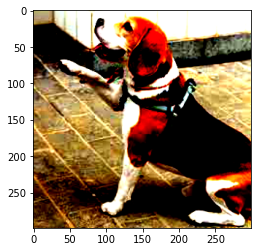

In [2]:

# model:c, h, w
# numpy, sklearn matplotlib: w, h, c
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# c, h, w

image = Image.open("../static/dog_paper.jpeg")
input = preprocess(image).unsqueeze(0)
# b, c, h, w

model = inception_v3(pretrained=True)
model.eval()

plt.imshow(input.squeeze().permute(1,2,0))
# h w c

with torch.no_grad():
    output = model(input)

print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)

with open("../static/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probs, 5)
    top5_prob, top5_catid = top5_prob.squeeze(), top5_catid.squeeze()
    for i in range(top5_prob.size(0)):
        print(top5_catid[i])
        print(categories[top5_catid[i]], top5_prob[i].item())

INFO: Start Sampling


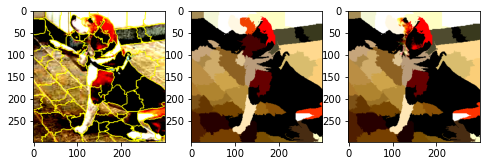

tensor([162])
tensor(0.2516, grad_fn=<SelectBackward0>)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

explainer = Anchor(Tasktype.IMAGE)

def predict(x):
    test = x.to(device)
    return model(test)

anchor, segments = explainer.explain_instance(input.squeeze().permute(1,2,0), predict, "None", 10000)

img, sp_img = explainer.visualize()
# Greedy segment test
img2 = img.copy()
mask = np.zeros(segments.shape).astype(bool)
for z in (11, 19):
    mask[segments == z] = True
img2[~mask] = sp_img[~mask]

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(mark_boundaries(img, segments))
fig.add_subplot(1, 3, 2)
plt.imshow(sp_img)
fig.add_subplot(1, 3, 3)
plt.imshow(img2)
plt.show()
# h w c

output = model(torch.Tensor(img2).permute(2,0,1).unsqueeze(0))
print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)
print(probs[162])


[11, 19]
1.0
[[ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 [ 1  1  1 ...  6  6  6]
 ...
 [62 62 62 ... 63 63 63]
 [62 62 62 ... 63 63 63]
 [62 62 62 ... 63 63 63]]
[11, 19]
[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [298 296]
 [298 297]
 [298 298]]


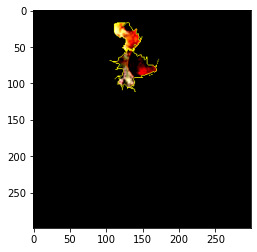

In [17]:
print(anchor.feature_mask)
print(anchor.precision)

print(segments)
print(anchor.feature_mask)
idxs = np.argwhere(~np.isin(segments,anchor.feature_mask))
print(idxs)
# input[:, idxs[:, 0], idxs[:, 1]] = 0
# plt.imshow(input.squeeze().permute(2,1,0))

img = mark_boundaries(input.squeeze().permute(1,2,0), segments)
img[idxs[:, 0], idxs[:, 1], :] = 0
plt.imshow(img)

In [16]:
# #h, w, c
# img.shape
print(input.shape)
model.to(device)
input[:,:, idxs[:, 0], idxs[:, 1]] = 0.34

output = model(input.to(device))
print(torch.argmax(output, dim=1))
probs = torch.nn.functional.softmax(output[0], dim=0)
print(probs[162])


torch.Size([1, 3, 299, 299])
tensor([733], device='cuda:0')
tensor(0.0019, device='cuda:0', grad_fn=<SelectBackward0>)


In [6]:
"""
Beam Search Test
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

explainer = Anchor(Tasktype.IMAGE)

def predict(x):
    test = x.to(device)
    return model(test)

anchor, segments = explainer.explain_instance(input.squeeze().permute(1,2,0), predict, "beam", 1000)

[ True]


False